# Assessing word embeddings for improving OCR accuracy

Our idea is to compare how different embeddings affect OCR accuracy, similar to the approach taken in this article: https://medium.com/states-title/using-nlp-bert-to-improve-ocr-accuracy-385c98ae174c (Links to an external site.)

We would like to try some embeddings we have learned about in the course, such as CBoW, word2vec, FastText, ELMo, BERT. If we have more time and find other interesting representations online we will evaluate them as well. The idea is to find a baseline OCR accuracy and then exploring if, and how much, this accuracy can be improved by applying word embeddings to the incorrectly scanned words. 

- Use a synthetic dataset (read in europarl corpus and corrupt it a bit)
- Richard suggests corrupting it in ways that often happen in OCR, like rn <-> m, i <-> l, cl <-> d 
    - (https://scribenet.com/articles/2016/03/04/how-to-get-the-most-out-of-ocr)
- I think he means we should use a spellchecker to find misspelled words, and check with NER that they are not a name
- Then maybe we don't throw out the misspelled word, it can be useful
- Richard thinks that character level embeddings can be useful here
- Evaluation of performance: see what people usually use within OCR. Some ideas:

    - https://www.aclweb.org/anthology/I17-1101.pdf
    - https://loicbarrault.github.io/papers/afli_cicling2015.pdf

In [1]:
import re
import time
import spacy
import torch
import difflib
import numpy as np
from enchant.checker import SpellChecker
from matplotlib import pyplot as plt

spell = SpellChecker("en-UK")
nlp = spacy.load('en_core_web_sm')

from transformers import AutoTokenizer, AutoModelForMaskedLM

# Read in and corrupt the corpus

Character elision is when letter pairs and individual letters are confused by the software. These types of errors occur any time pairs of letters are shaped similarly to other letters. Six common pairs are:

rn <-> m, cl <-> d, vv <-> w, ol <-> d, li <-> h, nn <-> m

In [7]:
elisionArray = []
elisionArray.append(['rn', 'm'])
elisionArray.append(['ol', 'd'])
elisionArray.append(['cl', 'd'])
elisionArray.append(['vv', 'w'])
elisionArray.append(['li', 'h'])
elisionArray.append(['nn', 'm'])
elisionArray = np.array(elisionArray)

## An example of how the character elision will be handled

In [8]:
# A test sentence that contains a lot of 'rn' and 'li'
line = "I scorn this little barn with my lilac yarn and delicious fern"
print(line)

new_line = line
elision_prob = 0.5

# Randomize search order, since some letter pairs overlap 
elisionArray = np.random.permutation(elisionArray)
for pair in elisionArray:
    
    n_errors = 0
    
    for m in re.finditer(pair[0], new_line):
        
        rd = np.random.rand(1)
        if rd < elision_prob:
            
            # Note that the position can't be used later since the line changes length!
            print("--> Replaced ", pair[0], " at position ", m.start(), "")
            
            tmp = list(new_line)
            tmp[m.start()-n_errors:m.end()-n_errors] = "%%"
            new_line = "".join(tmp)
            new_line = new_line.replace("%%", pair[1])
            
            print(new_line)

            # count number of replacements
            n_errors += 1
            
print('-'*80)

# Save location and correct spelling for the corrupted words

line = list(line.split())
new_line = list(new_line.split())

total_errors = 0
ground_truth = []

# This will be the index of a document in the corpus
doc_num = 0     

# This contains the ground truth for each document 
tmp = []

for j in range(len(line)):
    if line[j] != new_line[j]:
        
        total_errors += 1
        tmp.append((j, line[j]))
        
ground_truth.append((doc_num, tmp))
print("Total errors: ", total_errors)
print(ground_truth)

I scorn this little barn with my lilac yarn and delicious fern
--> Replaced  li  at position  13 
I scorn this httle barn with my lilac yarn and delicious fern
--> Replaced  rn  at position  21 
I scorn this httle bam with my lilac yarn and delicious fern
--> Replaced  rn  at position  59 
I scorn this httle bam with my lilac yarn and delicious fem
--------------------------------------------------------------------------------
Total errors:  3
[(0, [(3, 'little'), (4, 'barn'), (11, 'fern')])]


## Apply character elision to the Europarl data

### Function definitions

In [9]:
def check_line_errors(line, new_line, total_errors):
    
    """
    Check for errors between gold standard document and "OCR" document.
    """

    line = list(line.split())
    new_line = list(new_line.split()) 
    truth = []

    for j in range(len(line)):
        if line[j] != new_line[j]:

            total_errors += 1
            truth.append((j, line[j]))
    
    return truth, total_errors


def apply_elision(line, elision_array, elision_prob):
    
    """
    Apply elision to a line of text. An observed pair will be exchanged with probability elision_prob.
    """
    
    # Randomize search order, since some letter pairs overlap 
    elision_array = np.random.permutation(elision_array)
    for elision_pair in elision_array:

        # Count number of times each letter pair has been corrupted (since this changes the line length)
        n_errors = 0 

        for m in re.finditer(elision_pair[0], line):

            rd = np.random.rand(1)
            if rd < elision_prob:

                # Replace the letter pair and convert to a new line
                tmp = list(line)
                tmp[m.start()-n_errors:m.end()-n_errors] = "%%"
                line = "".join(tmp)
                line = line.replace("%%", elision_pair[1])

                # count number of replacements
                n_errors += 1

    return line


def read_data(corpus_file, corpus_encoding, max_lines, elision_array, elision_prob):
    
    """
    Read in ground truth version of the text, and a (synthetic) corrupted OCR dataset.
    """
    
    total_errors = 0
    ground_truth = []
    corrupted_data = []
    line_indices = []
    elision_errors = []
    
    with open(corpus_file, encoding = corpus_encoding) as f:
        
        for d, line in enumerate(f):
        
            if d == max_lines:
                break
        
            # Apply elision and keep track of which words have been corrupted
            new_line = apply_elision(line, elision_array, elision_prob)  
            line_truth, total_errors = check_line_errors(line, new_line, total_errors)
            
            if len(line_truth) > 0:
                line_indices.append(d)
                elision_errors.append(line_truth)
                
            # Append original and (potentially) corrupted line
            ground_truth.append(line) 
            corrupted_data.append(new_line)
                
    elisions = (line_indices, elision_errors)
            
    return ground_truth, corrupted_data, elisions, total_errors

In [10]:
def contains_numbers(string):
    
    """
    Check if the given string contains any digits.
    """
    
    return any(char.isdigit() for char in string)


def is_part_of_name(line, word):
    
    """
    Using spacy for NER, we check if a specific word is part of a name.
    """
    
    # Apply nlp pipeline, check if this "misspelled word" is a name
    result = nlp(line, disable = ['tagger', 'parser'])
    is_name = False

    for entity in result.ents:
        # If the "misspelled" word is part of the name of a person, country etc - we ignore it
        if entity.label_ in  ["PERSON", "NORP", "GPE", "ORG"] and entity.text.find(word) > -1:
            is_name = True

    return is_name


def identify_spelling_errors(data, ignore):

    """
    Given a dataset and a list of characters to ignore, find misspelled words that are _not_ names.
    """
    
    n_misspelled = 0
    line_indices = []
    spelling_errors = []
    spelling_corrected = []
    not_in_english = []

    for d, line in enumerate(data):

        words = line.split()
        tmp_1 = []
        tmp_2 = []
        
        for i, word in enumerate(words):

            # Some dates and similar are marked as misspelled - ignore words containing numbers!
            if not word in ignore and not contains_numbers(word):
            
                # Apply a spell checker
                if not spell.check(word):
        
                    # Check if the word is part of a name
                    if not is_part_of_name(line, word):

                        try:
                            # Apply a spell correction to the word
                            corrected_word = spell.suggest(word)[0]
                            
                            # Note down word and position
                            tmp_1.append((i, word))
                            tmp_2.append((i, corrected_word))
                            n_misspelled += 1

                        except IndexError:

                            # If no spelling suggestions exist, the line is usually not in English. 
                            # The EU parlaiment uses many languages, exclude the line just in case.
                            not_in_english.append(d)
        
        # If spelling errors were found, save the line and words.
        if len(tmp_1) > 0:
            line_indices.append(d)
            spelling_errors.append(tmp_1)
            spelling_corrected.append(tmp_2)
            
    spelling_errors = (line_indices, spelling_errors)
    spelling_corrected = (line_indices, spelling_corrected)

    return spelling_errors, spelling_corrected, n_misspelled, not_in_english

In [11]:
def remove_excl_lines(data, excl_lines):
    
    """
    Remove given lines, by index, from a dataset.
    """
    
    for i, line in enumerate(excl_lines):
        del data[line-i]

        
def remove_excl_entries(entries, count, excl_lines):
    
    """
    Given lines to exclude, by index, remove them from the data structure at the right position. Also adjust count.
    """
    
    a = set(excl_lines)
    b = set(entries[0])
    
    for line_idx in a & b:
            
        # Find position of the line to be removed
        list_pos = entries[0].index(line_idx)
        
        # Adjust the word count
        count -= len(entries[1][list_pos])

        # Delete the identified entries
        del entries[0][list_pos]
        del entries[1][list_pos]
          
    return entries, count

### Run the code

In [273]:
file = "europarl.txt"
encoding = "utf-8"

# Probability that a letter pair from our list will be confused if it is seen in the text
elision_prob = 0.5
max_lines = 30

np.random.seed(0)
ground_truth, data, elisions, n_elisions = read_data(file, encoding, max_lines, elisionArray, elision_prob)

In [274]:
# Words and characters for the spellchecker to ignore
ignore = [",", ".", '"', "(", ")", "-", "'", "!", "?", ":", ";", "/", 
          "n't", "'s", "'m", "%", "--", "``", "___LANGCODE___", "''"]
spell_errors, spell_corrected, n_misspelled, excl_lines = identify_spelling_errors(data, ignore)

print("Number of identified misspelled words: ", n_misspelled)
print("Number of synthetic errors: ", n_elisions)

Number of identified misspelled words:  12
Number of synthetic errors:  14


In [272]:
def match_and_split(indices, datastruct):
    
    tmp_idx = []
    tmp_info = []
    
    for i in indices:
        if i in datastruct[0]:
            tmp_idx.append(i)
            j = datastruct[0].index(i)
            tmp_info.append(datastruct[1][j])
            
    return (tmp_idx, tmp_info)

def train_test_split(data, elisions, spell_errors, spell_corrected, train_frac = 0.7):
    
    train_len = int(len(data)*train_frac)
    
    line_vec = np.random.permutation(len(data))
    train_lines = np.sort(line_vec[:train_len])
    test_lines = np.sort(line_vec[train_len:])
    
    train_data = []
    for i in train_lines:
        train_data.append(data[i])

    train_elisions = match_and_split(train_lines, elisions)
    train_errors = match_and_split(train_lines, spell_errors)
    train_corrected = match_and_split(train_lines, spell_corrected)
    
    test_data = []
    for i in test_lines:
        test_data.append(data[i])
        
    print(test_lines)
    test_elisions = match_and_split(test_lines, elisions)
    test_errors = match_and_split(test_lines, spell_errors)
    test_corrected = match_and_split(test_lines, spell_corrected)
            
    return (train_data, train_elisions, train_errors, train_corrected), (test_data, test_elisions, test_errors, test_corrected)
    

In [257]:
train, test = train_test_split(data, elisions, spell_errors, spell_corrected, train_frac = 0.7)
train_data, train_elisions, train_errors, train_corrected = train
test_data, test_elisions, test_errors, test_corrected = test

[0 3 5]


In [263]:
bert_corrected = masked_prediction(data, spell_errors, tokenizer, model, spell_corrected, use_suggestions = False)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(elisions, bert_corrected, data)

True positives:  2
True negatives:  4
False negatives:  2
False positives:  0
Incorrect edits:  2
---------------------------------------------------------------------------
Detection accuracy:  0.8
Correction accuracy:  0.6


In [264]:
bert_corrected = masked_prediction(train_data, train_errors, tokenizer, model, train_corrected, use_suggestions = False)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(train_elisions, bert_corrected, train_data)

IndexError: list index out of range

While spell checking, some words might appear that have no spelling suggestions. These words tend to be in French or German, since the EU parliament uses these languages occasionally in quotes. It's not fair to ask the spell checker to handle these words, and the purpose here is not to handle multiple different languages. However the impact of this is minimal: in the first 10 000 documents of the corpus, only 6 are affected. Thus we can safely ignore this language issue in this corpus.

If there are entries in excl_lines, make adjustments as described above. (a bit buggy, have to fix this)

remove_excl_lines(data, excl_lines)
remove_excl_lines(ground_truth, excl_lines)

elisions, n_elisions = remove_excl_entries(elisions, n_elisions, excl_lines)
spell_errors, n_misspelled = remove_excl_entries(spell_errors, n_misspelled, excl_lines)
spell_corrected, _ = remove_excl_entries(spell_corrected, n_misspelled, excl_lines)

# Compute baseline accuracy using spellcheck suggestions

- https://www.aclweb.org/anthology/I17-1101.pdf

[From the article] For evaluation, we use the CER (Character Error Rate) metric, which does not seem to be useful in this setting. We want to measure the systems performance per input, rather than per character. We therefore introduce two accuracy-based evaluation metrics (also mentioned in the article), which evaluate on the level of the character window:
- detection accuracy (detAcc) shows the proportion of correctly detected errors and nonerrors in the evaluated set of 20-character strings
- correction accuracy (corrAcc) reflects the ability of the language model to accurately correct corrupted strings without overgenerating and editing non-corrupted strings

These metrics are calculated as follows:

$detAcc = \frac{(TP + TN + incorrectEdit)}{(TP + TN + FP + FN + incorrectEdit)}$

$corrAcc = \frac{(TP + TN)}{(TP + TN + FP + FN + incorrectEdit)}$

- TP: There is an error on the line, which is corrected.
- TN: No error on the line, no correction
- FP: No error on the line, makes a correction anyway
- FN: There is an error on the line, but it's not corrected
- incorrectEdit: Error is identified, but the correction is wrong.

In [13]:
def compute_accuracy_scores(elisions, corrections, data, verbose = True):
    
    elision_idx = elisions[0]
    elision_words = elisions[1]
    corrected_idx = corrections[0]
    corrected_words = corrections[1]
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    incorrect_edits = 0
    
    # True positives = number of correct changes
    for pos1, idx in enumerate(elision_idx):
        if idx in corrected_idx:
            
            pos2 = corrected_idx.index(idx)
            
            if elision_words[pos1] == corrected_words[pos2]:
                TP += 1
            else:
                incorrect_edits += 1

    # True negatives = number of lines that do not have elision, and that have not been touched by spellchecker
    corpus_size = len(data)
    all_touched_lines = set(corrected_idx) | set(elision_idx)
    TN = corpus_size - len(all_touched_lines)
    
    # False negatives = lines that should have been changed, but were not
    false_neg_lines = set(elision_idx) - set(corrected_idx)
    FN = len(false_neg_lines)
    
    # False positives = there was no elision, but a correction was made anyway
    false_pos_lines = set(corrected_idx) - set(elision_idx)
    FP = len(false_pos_lines)
        
    # Double check that it all adds up
    if FP + FN + TN + TP + incorrect_edits != corpus_size:
        print("ERROR: These scores don't add up to the number of lines!")
        
    # Compute accuracy scores    
    det_accuracy = (TP + TN + incorrect_edits)/corpus_size
    corr_accuracy = (TP + TN)/corpus_size
    
    if verbose == True:
        
        print("True positives: ", TP)  
        print("True negatives: ", TN)
        print("False negatives: ", FN)
        print("False positives: ", FP)
        print("Incorrect edits: ", incorrect_edits)
        print("-"*75)
        print("Detection accuracy: ", np.round(det_accuracy, 4))
        print("Correction accuracy: ", np.round(corr_accuracy, 4))
    
    return det_accuracy, corr_accuracy


In [67]:
det_acc, corr_acc = compute_accuracy_scores(elisions, spell_corrected, data)

True positives:  3
True negatives:  27
False negatives:  4
False positives:  1
Incorrect edits:  15
---------------------------------------------------------------------------
Detection accuracy:  0.9
Correction accuracy:  0.6


# Try to fill in missing words using BERT 

In [19]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
model_name_2 = 'distilbert-base-uncased'
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)
model_2 = AutoModelForMaskedLM.from_pretrained(model_name_2).eval()

In [55]:
model_name_3 = 'google/electra-small-discriminator'
tokenizer_3 = AutoTokenizer.from_pretrained(model_name_3)
model_3 = AutoModelForMaskedLM.from_pretrained(model_name_3).eval()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForMaskedLM: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['generator_predictions.LayerNorm.weight', 'generator_predictions.La

### Function definitions

In [312]:
def find_best_suggestion(word, suggestions):
    
    """
    Find the spelling suggestion that best matches a given word.
    """
    
    dict, max = {}, 0
    a = set(suggestions)

    for b in a:

        tmp = difflib.SequenceMatcher(None, word, b).ratio();
        dict[tmp] = b

        if tmp > max:
            max = tmp

    return(dict[max])

In [300]:
def create_segments_tensors(tokenized_text):
    
    """
    Given a line of tokenized text, create segments tensors needed for maskedLM. 
    """
    
    segs = [i for i, e in enumerate(tokenized_text) if e == "."]
    segments_ids=[]
    prev=-1
    for k, s in enumerate(segs):
        segments_ids = segments_ids + [k] * (s-prev)
        prev=s
    segments_ids = segments_ids + [len(segs)] * (len(tokenized_text) - len(segments_ids))
    segments_tensors = torch.tensor([segments_ids])
    
    return segments_ids, segments_tensors


def masked_LM_oneline(tokenizer, model, line, line_info, use_word=False, n_suggestions=None):
    
    """
    Perform masked LM on one line of text and return the top predictions, given a tokenizer and model.
    """
    
    # Replace misspelled words with MASK token
    split_line = line.split()
    for item in line_info:
        split_line[item[0]] = '[MASK]'
    line = " ".join(split_line)
    
    # Load, train and predict using pre-trained model
    tokenized_text = tokenizer.tokenize(line)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    MASKIDS = [i for i, e in enumerate(tokenized_text) if e == '[MASK]']

    # Create the segments tensors
    segments_ids, segments_tensors = create_segments_tensors(tokenized_text)

    # Predict all tokens
    with torch.no_grad():
        predictions = model(tokens_tensor, segments_tensors)

    # Process and display top prediction at each position
    mask_predictions = []

    if use_word == False:
        
        for mask_idx in MASKIDS:
            word_int = predictions[0][0, mask_idx, :].topk(1).indices.tolist()
            word_text = tokenizer.convert_ids_to_tokens(word_int)        
            mask_predictions.append(word_text[0])
    else:
        
        for k, mask_idx in enumerate(MASKIDS):

            word_int = predictions[0][0, mask_idx, :].topk(n_suggestions).indices.tolist()
            word_text = tokenizer.convert_ids_to_tokens(word_int)
            original_word = line_info[k][1]
            best = find_best_suggestion(original_word, word_text)
            mask_predictions.append(best)
        
    return mask_predictions


def masked_prediction(data, spell_errors, tokenizer, model, use_word=False, n_suggestions=5):   
    
    """
    Given a dataset and locations of misspelled words, perform masked prediction to replace the words. 
    Can either use information about the misspelled words, or disregard them entirely.
    """
    
    corrected = []

    for i in range(len(spell_errors[0])):

        line_idx = spell_errors[0][i]
        line_info = spell_errors[1][i]
        line = data[line_idx]           # this kind of indexing doesn't work with train_test split

        # Retrieve prediction using masked LM
        preds = masked_LM_oneline(tokenizer, model, line, line_info, use_word, n_suggestions)
        
        # Save the results
        tmp = []
        for j, item in enumerate(line_info):
            idx = item[0]
            tmp.append((idx, preds[j]))

        corrected.append(tmp)
        
    corrected = (spell_errors[0], corrected)
    return corrected

### An example

In [316]:
# Find a good example document to use BERT on

example_idx = 6

print(spell_errors[0][example_idx], spell_errors[1][example_idx])

line_idx = spell_errors[0][example_idx]
line_info = spell_errors[1][example_idx]
line = data[line_idx]

print(line)

preds = masked_LM_oneline(tokenizer, model, line, line_info, use_word=True, n_suggestions=5 )

print(preds)

18 [(39, 'disabihties'), (50, 'famihes')]
People with disabilities are not divided into sectors or compartments of inactivity , they are girls and boys , men and women who are entitled to full integration , not integration in some areas : thousands of children with disabihties in Europe still live in institutes rather than with their famihes , for example .

['disabilities', 'families']


### Running the code with Bert - different number of guesses

In [301]:
bert_corrected_1 = masked_prediction(data, spell_errors, tokenizer, model, use_word = False)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(elisions, bert_corrected_1, data)

True positives:  2
True negatives:  16
False negatives:  3
False positives:  1
Incorrect edits:  8
---------------------------------------------------------------------------
Detection accuracy:  0.8667
Correction accuracy:  0.6


In [307]:
bert_corrected_2 = masked_prediction(data, spell_errors, tokenizer, model, use_word = True, n_suggestions = 5)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(elisions, bert_corrected_2, data)

True positives:  3
True negatives:  16
False negatives:  3
False positives:  1
Incorrect edits:  7
---------------------------------------------------------------------------
Detection accuracy:  0.8667
Correction accuracy:  0.6333


In [311]:
bert_corrected_3 = masked_prediction(data, spell_errors, tokenizer, model, use_word = True, n_suggestions = 10)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(elisions, bert_corrected_3, data)

True positives:  5
True negatives:  16
False negatives:  3
False positives:  1
Incorrect edits:  5
---------------------------------------------------------------------------
Detection accuracy:  0.8667
Correction accuracy:  0.7


Note that accepting more word suggestions from Bert can increase the accuracy to an extent. This only affects the number of true positives and incorrect edits - if n_suggestions is chosen well, we can convert a maximum amount of incorrect edits into true positives. Accepting more word suggestions after this point only increases the incorrect edits again.

Tune this parameter on a training part of the corpus, then validate it! Other ways to improve incorrect edits?

What fraction of elisions are never discovered? Check if false negative rate remains roughly constant - these might be words that end up being a correctly spelled word after elisions. How much better are we than the enchant spellchecker?

In [318]:
start = time.time()
corr_acc_vec = []

for n_suggestions in range(1, 50, 5):
    bert_corr = masked_prediction(data, spell_errors, tokenizer, model, use_word = True, n_suggestions = n_suggestions)
    _, acc = compute_accuracy_scores(elisions, bert_corr, data, verbose = False)
    corr_acc_vec.append(acc)
    
print("Elapsed time: ", time.time() - start)

Elapsed time:  11.086012840270996


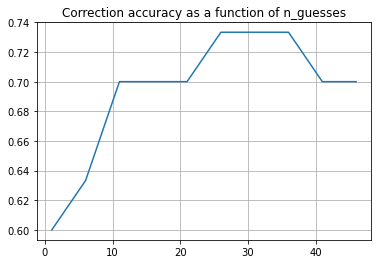

In [319]:
plt.plot(range(1, 50, 5), corr_acc_vec)
plt.title("Correction accuracy as a function of n_guesses")
plt.grid(True)
plt.show()

In [23]:
# Double check what went wrong with the deletion of lines
# Use convolutional representation? Can that find the elisions that are not misspelled?
# Can apply this on top of the existing method, or instead of it

### Accuracy as a function of elision_prob

In [321]:
def evaluation_pipeline(file, encoding, elisionArray, elision_probs, max_lines, ignore_list, n_suggestions, verbose = True):
    
    """
    Pipeline for loading in data with different levels of elision probability, and applying the Bert model. 
    """
    
    start = time.time()
    corr_acc_vec = []
    n_elisions_vec = []
    
    for elision_prob in elision_probs:
    
        ground_truth, data, elisions, n_elisions = read_data(file, encoding, max_lines, elisionArray, elision_prob)
        spell_errors, spell_corrected, n_misspelled, excl_lines = identify_spelling_errors(data, ignore_list)
        n_elisions_vec.append(n_elisions)
        
        if verbose == True:
            
            print("Number of identified misspelled words: ", n_misspelled)
            print("Number of synthetic errors: ", n_elisions)
            print("="*75)

        bert_corrected = masked_prediction(data, spell_errors, tokenizer, model, use_word=True, n_suggestions=n_suggestions)
        _, acc = compute_accuracy_scores(elisions, bert_corrected, data, verbose = False)    
        corr_acc_vec.append(acc)
        
    print("Elapsed time: ", time.time() - start)
        
    return corr_acc_vec, n_elisions_vec

In [ ]:
elision_probs = np.linspace(0, 1, 5)
n_lines = 50

corr_vec_1, n_elisions_1 = evaluation_pipeline(file, encoding, elisionArray, elision_probs, 
                                 max_lines = n_lines, ignore_list = ignore, n_suggestions = 1, verbose = False)
corr_vec_5, n_elisions_5 = evaluation_pipeline(file, encoding, elisionArray, elision_probs, 
                                 max_lines = n_lines, ignore_list = ignore, n_suggestions = 5, verbose = False)
corr_vec_15, n_elisions_15 = evaluation_pipeline(file, encoding, elisionArray, elision_probs, 
                                 max_lines = n_lines, ignore_list = ignore, n_suggestions = 15, verbose = False)

In [ ]:
plt.plot(elision_probs, corr_vec_1, label = "1")
plt.plot(elision_probs, corr_vec_5, label = "5")
plt.plot(elision_probs, corr_vec_15, label = "15")
plt.title("Correction accuracy as a function of elision probability")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(elision_probs, n_elisions_1, label = "1")
plt.plot(elision_probs, n_elisions_5, label = "5")
plt.plot(elision_probs, n_elisions_15, label = "15")
plt.title("Number of elisions as a function of elision probability")
plt.grid(True)
plt.legend()
plt.show()

# some variability in number of elisions but that's fine

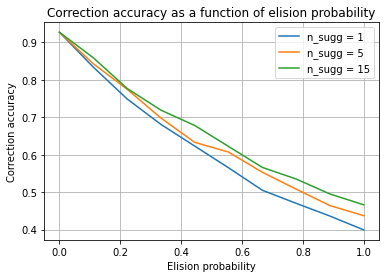

In [84]:
plt.plot(elision_probs, corr_vec_1, label = "n_sugg = 1")
plt.plot(elision_probs, corr_vec_5, label = "n_sugg = 5")
plt.plot(elision_probs, corr_vec_15, label = "n_sugg = 15")
plt.title("Correction accuracy as a function of elision probability")
plt.xlabel("Elision probability")
plt.ylabel("Correction accuracy")
plt.grid(True)
plt.legend()
#plt.savefig('elision_prob.png')

### Distilbert - does this give suggestions in the same way?

In [56]:
distilbert_corrected = masked_prediction(data, spell_errors, tokenizer_2, model_2, False, spell_corrected)
det_acc_distilbert, corr_acc_distilbert = compute_accuracy_scores(elisions, distilbert_corrected, data)

True positives:  0
True negatives:  65
False negatives:  4
False positives:  1
Incorrect edits:  30
---------------------------------------------------------------------------
Detection accuracy:  0.95
Correction accuracy:  0.65


In [59]:
distilbert_corrected = masked_prediction(data, spell_errors, tokenizer_2, model_2, True, spell_corrected, n_guesses = 10)
det_acc_distilbert, corr_acc_distilbert = compute_accuracy_scores(elisions, distilbert_corrected, data)

True positives:  0
True negatives:  65
False negatives:  4
False positives:  1
Incorrect edits:  30
---------------------------------------------------------------------------
Detection accuracy:  0.95
Correction accuracy:  0.65


### Electra - does this give suggestions in the same way?

In [61]:
electra_corrected = masked_prediction(data, spell_errors, tokenizer_3, model_3, False, spell_corrected)
det_acc_electra, corr_acc_electra = compute_accuracy_scores(elisions, electra_corrected, data)

True positives:  0
True negatives:  65
False negatives:  4
False positives:  1
Incorrect edits:  30
---------------------------------------------------------------------------
Detection accuracy:  0.95
Correction accuracy:  0.65


In [62]:
electra_corrected = masked_prediction(data, spell_errors, tokenizer_3, model_3, True, spell_corrected, n_guesses = 5)
det_acc_electra, corr_acc_electra = compute_accuracy_scores(elisions, electra_corrected, data)

True positives:  0
True negatives:  65
False negatives:  4
False positives:  1
Incorrect edits:  30
---------------------------------------------------------------------------
Detection accuracy:  0.95
Correction accuracy:  0.65


# Try using bigrams 
This could catch when an incorrectly scanned word becomes another, correctly spelled word: for example, God -> Cod. The spell checker will not react to this, but it should create a strange bigram

# Try some other word embeddings

two approaches: either throw away the misspelled word and try to fill it in from context, or use character level embeddings 

# Try some character level embeddings